Random Forest (gradient boosted maybe) vs. PyTorch. 

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, classification_report
# from sklearnex import patch_sklearn
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# patch_sklearn

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [45]:
df = pd.read_csv('./data/kaggle_neo.csv')

df.head()

,Designation,Discovery Date (YYYY-MM-DD),H (mag),MOID (au),q (au),Q (au),period (yr),i (deg),PHA,Orbit Class
0,(2024 FL4),2024-03-31,21.61,0.094,1.07,3.77,3.76,15.59,N,Amor
1,(2024 ET5),2024-03-14,20.68,0.235,1.16,4.23,4.42,15.23,N,Amor
2,(2024 EO2),2024-03-01,19.08,0.192,1.19,4.55,4.86,54.74,N,Amor
3,(2024 AP7),2024-01-15,19.79,0.224,0.59,2.91,2.31,24.54,N,Apollo
4,(2024 AF6),2024-01-13,20.67,0.134,0.43,1.02,0.62,15.05,N,Aten


In [46]:
not_na_df =df[df['PHA'].notna()]
filtered_set = not_na_df.drop(columns='Discovery Date (YYYY-MM-DD)')
filtered_set.columns = [col.replace(' ', '_') for col in filtered_set.columns]
filtered_set['binary_PHA'] = pd.get_dummies(filtered_set['PHA'], dtype=int)['Y']
filtered_set = filtered_set.copy()
filtered_set['Designation'] = filtered_set['Designation'].str.extract(r'\((?:\d{4}\s)?([A-Z]+\d+)\)')
filtered_set = filtered_set[filtered_set['Orbit_Class'].isin(['Amor', 'Apollo', 'Aten'])].copy()
filtered_set['a'] = (filtered_set['Q_(au)'] + filtered_set['q_(au)'])/2
filtered_set['e'] = (filtered_set['Q_(au)'] - filtered_set['q_(au)']) / (filtered_set['Q_(au)'] + filtered_set['q_(au)'])
filtered_set.columns

Index(['Designation', 'H_(mag)', 'MOID_(au)', 'q_(au)', 'Q_(au)',
       'period_(yr)', 'i_(deg)', 'PHA', 'Orbit_Class', 'binary_PHA', 'a', 'e'],
      dtype='object')

In [47]:
feature_cols = ['H_(mag)', 'MOID_(au)',
                'q_(au)', 'Q_(au)',
                'period_(yr)', 'i_(deg)',
                'a', 'e'
]

X = filtered_set[feature_cols].values.astype(np.float32)
y = (filtered_set['PHA'] == "Y").astype(int).values # 0 or 1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=55, stratify=y
)


In [48]:
rf = RandomForestClassifier(
    n_estimators=500,
    class_weight='balanced',
    random_state=55,
    n_jobs=-1
)

rf.fit(X_train, y_train)

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [49]:
#eval
rf_probs = rf.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_probs)

print(f'Random Forest ROC AUC: {rf_auc:.4f}')

Random Forest ROC AUC: 1.0000


In [50]:
# get hwo important each feature is

importances = rf.feature_importances_
for col, imp in sorted(zip(feature_cols, importances), key=lambda x: -x[1]):
    print(f"{col:<12}: {imp:.4f}")

MOID_(au)   : 0.5628
H_(mag)     : 0.1358
q_(au)      : 0.0934
e           : 0.0545
Q_(au)      : 0.0463
period_(yr) : 0.0420
a           : 0.0347
i_(deg)     : 0.0305


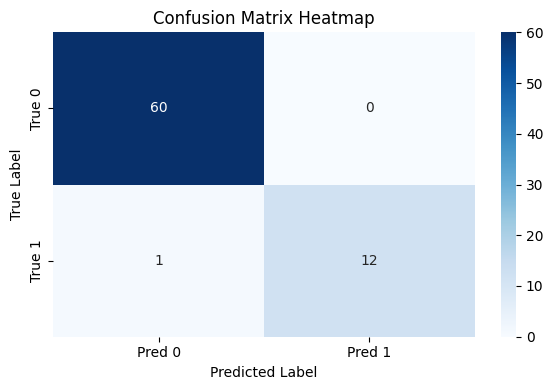

In [51]:
#confusing confusion matrix

y_pred = (rf_probs > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["True 0", "True 1"]
)

plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [52]:
#hyperparameter tuning
param_grid_binary = {
    "n_estimators": [200, 400, 600],
    "max_depth": [50,75,100],
    "min_samples_split": [50,75,100],
    "min_samples_leaf": [50,75,100],
    "max_features": ["sqrt", "log2",0.8],
    "bootstrap": [True, False],
    "class_weight": ["balanced"]
}

rf = RandomForestClassifier(random_state=55, n_jobs=-1)

grid_binary = GridSearchCV(
    rf,
    param_grid=param_grid_binary,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_binary.fit(X_train, y_train)

print("Best params (Binary PHA):", grid_binary.best_params_)
print("Best cross-val ROC AUC:", grid_binary.best_score_)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best params (Binary PHA): {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 200}
Best cross-val ROC AUC: 0.9300656834300451


In [53]:
best_rf_binary = grid_binary.best_estimator_
yb_pred = best_rf_binary.predict(X_test)
rf_probs = best_rf_binary.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_probs)

print("Binary PHA Test ROC AUC:", rf_auc)
print(classification_report(y_test, yb_pred, target_names=["Not Hazard", "Hazard"]))

Binary PHA Test ROC AUC: 0.9487179487179487
              precision    recall  f1-score   support

  Not Hazard       1.00      0.87      0.93        60
      Hazard       0.62      1.00      0.76        13

    accuracy                           0.89        73
   macro avg       0.81      0.93      0.85        73
weighted avg       0.93      0.89      0.90        73



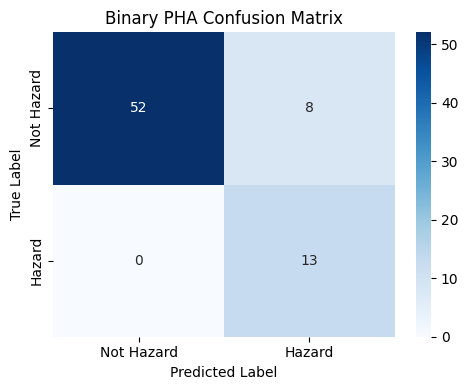

In [54]:
# confusion matrix
cm = confusion_matrix(y_test, yb_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Hazard", "Hazard"],
            yticklabels=["Not Hazard", "Hazard"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Binary PHA Confusion Matrix")
plt.tight_layout()
plt.show()

now class prediction

In [55]:
filtered_set.columns

Index(['Designation', 'H_(mag)', 'MOID_(au)', 'q_(au)', 'Q_(au)',
       'period_(yr)', 'i_(deg)', 'PHA', 'Orbit_Class', 'binary_PHA', 'a', 'e'],
      dtype='object')

In [56]:
# need to label encode orbit classes
le = LabelEncoder()

filtered_set['orbit_label'] = le.fit_transform(filtered_set['Orbit_Class'])

le.classes_

array(['Amor', 'Apollo', 'Aten'], dtype=object)

In [57]:
#going to use same featured cols

X = filtered_set[feature_cols]
y = filtered_set['orbit_label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=55, stratify=y
)

In [58]:
#try with random forest again
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    class_weight ='balanced',
    random_state=55,
    n_jobs=-1
)

rf.fit(X_train, y_train)

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [59]:
y_pred = rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)

print("Accuracy:", acc)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.9863013698630136

Classification Report:
              precision    recall  f1-score   support

        Amor       0.96      1.00      0.98        25
      Apollo       1.00      0.98      0.99        42
        Aten       1.00      1.00      1.00         6

    accuracy                           0.99        73
   macro avg       0.99      0.99      0.99        73
weighted avg       0.99      0.99      0.99        73



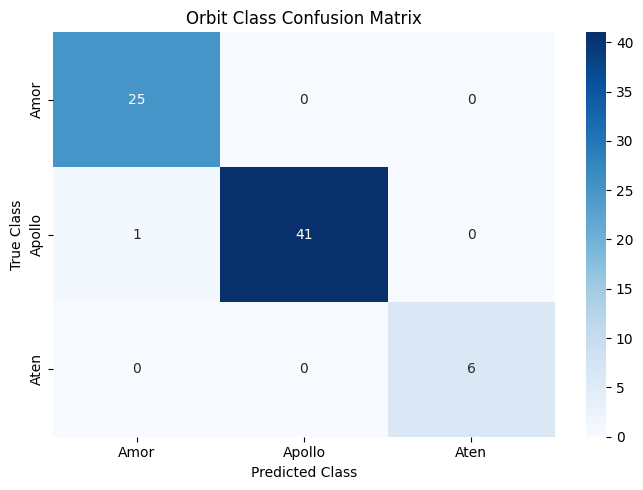

In [60]:

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Orbit Class Confusion Matrix")
plt.tight_layout()
plt.show()


Random forst seems strong for both

In [ ]:
#Hyperparameter tuning
param_grid_multi = {
    "n_estimators": [200, 400, 600],
    "max_depth": [40,60,80],
    "min_samples_split": [40,60,80],
    "min_samples_leaf": [40,60,80],
    "max_features": ["sqrt", "log2",0.8],
    "bootstrap": [True, False],
    "class_weight": ["balanced"]
}
rf_multi = RandomForestClassifier(random_state=55, n_jobs=-1)

grid_multi = GridSearchCV(
    rf_multi,
    param_grid=param_grid_multi,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_multi.fit(X_train, y_train)
best_rf_multi = grid_multi.best_estimator_
y_pred_multi = best_rf_multi.predict(X_test)
print("Best params (Multi-class Orbit):", grid_multi.best_params_)
print("Best cross-val ROC AUC:", grid_multi.best_score_)
print(classification_report(y_test, y_pred_multi, target_names=le.classes_))

Fitting 5 folds for each of 1536 candidates, totalling 7680 fits
Best params (Multi-class Orbit): {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 40, 'min_samples_split': 40, 'n_estimators': 200}
Best cross-val ROC AUC: 0.9068965517241379
              precision    recall  f1-score   support

        Amor       0.96      1.00      0.98        25
      Apollo       1.00      0.83      0.91        42
        Aten       0.50      1.00      0.67         6

    accuracy                           0.90        73
   macro avg       0.82      0.94      0.85        73
weighted avg       0.95      0.90      0.91        73



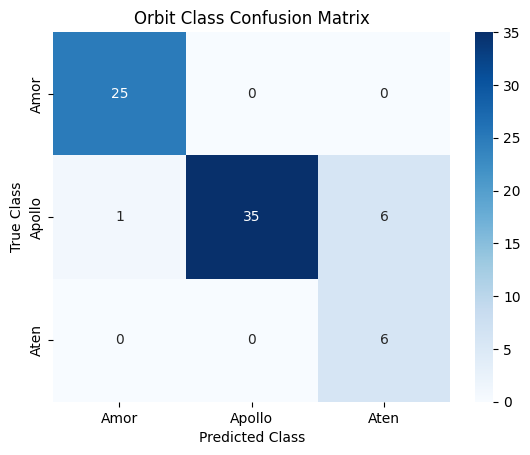

In [67]:
cm = confusion_matrix(y_test, y_pred_multi)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Orbit Class Confusion Matrix")
plt.show()